In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl 
%matplotlib inline
mpl.rcParams['patch.force_edgecolor'] = True
sns.set()

In [2]:
df_nyt_yelp = pd.read_pickle('import/df_nyt_yelp.pkl') # import nyt-yelp master dataframe
df_reviews = pd.read_pickle('import/df_reviews.pkl')

# 1. Yelp reviews - NLP corpus

## 1.1 NLP pre-processing

Generate a pre-processed, tokenized list of documents in preparation for using gensim to create a corpus. Here, a <u>document</u> = a review's text. Each document is converted to a list of pre-processed tokens (not unique - will list all instances of tokens).

Pre-processing steps: 
- Lowercase
- Remove non-alphabetic characters/punctuation
- Remove stop words
- Lemmatize
- Correct (some) misspellings w/ [TextBlob](http://textblob.readthedocs.io/en/dev/)

In [3]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
#from textblob import TextBlob # when this is commented out, we are running w/o TextBlob corrections, because it adds ~20 hrs

text_tokenized = []
text_preprocessed = []

for idx, review in df_reviews.iterrows():
    
    # basic pre-processing
    text = review['review_text'].lower() # lowercase doc
    #text = str(TextBlob(text).correct())
    
    text2 = word_tokenize(text) # tokenize doc
    text3 = [tok for tok in text2 if tok.isalpha()] # retain only alphabetic words
    
    # remove stopwords
    stop_words = set(stopwords.words('english')) # generate stopwords from English dictionary
    text4 = [tok for tok in text3 if tok not in stop_words]
    
    # lemmatize tokens
    wordnet_lemmatizer = WordNetLemmatizer()
    text5 = [wordnet_lemmatizer.lemmatize(tok) for tok in text4]
    
    text6 = ' '.join(text5)
    # correct some misspellings
    #text6 = [str(TextBlob(tok).correct()) for tok in text5]
    
    text_tokenized.append(text5)
    text_preprocessed.append(text6)

df_reviews['text_preprocessed'] = text_preprocessed

## 1.2 Create corpus w/ gensim

We use [gensim](https://radimrehurek.com/gensim/) to create a corpus, where each token is mapped to a unique numerical ID and word count (i.e. bag of words, BoW) in order to set up structure for inputting to NLP algorithms.

In [4]:
from gensim.corpora.dictionary import Dictionary

# create dictionary from list of pre-processed tokens (all instances) across all documents ('lemmatized')
dictionary = Dictionary(text_tokenized)

# generate corpus
corpus = [dictionary.doc2bow(doc) for doc in text_tokenized] # .doc2bow method converts documents into BoW format

c:\users\diana\appdata\local\programs\python\python36-32\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Visualize a sample review under our different processing steps leading up to gensim corpus.

In [17]:
print('Review (after pre-processing): ', text, '\n')
print('Review (after document tokenization, removing stopwords, lemmatization): ', text5, '\n')
print('Review (after gensim corpus): ', corpus[-1])

Review (after pre-processing):  i don't give 5 stars often, unless it was truly a stellar meal. and of course it doesn't have to be a stuffy fancypants place to be stellar, although sometimes it is. shuko was one of those upscale places and was truly, from the bottom of my heart, one of the best meals i've ever had. it's so badass that the door isn't even marked- it's this elite club that you enter because you know about it already. i got the omakase menu, every bite was carefully prepared in front of my eyes before being placed on my little stone tray and then popped into my mouth. it was as if centuries of preparation and thought had gone into the making of each bite; the culture and technique behind the assembly of the sushi, the flavor and texture profiles, the quality of the ingredients... i think when i went through that unmarked black door, i went to narnia and then reemerged into the mundane world upon exit. sake was phenomenal. i tasted everything that the sommelier (sakelier?

#### Create dataframe of corpus, which tracks the restaurant that the review belongs to

In [5]:
df_corpus = pd.DataFrame({'restaurant_idx':df_reviews['review_idx'], 
                          'corpus':corpus, 
                          'yelp_rating':df_reviews['rating']})
df_corpus.head()

,corpus,restaurant_idx,yelp_rating
0,"[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...",0,5
1,"[(17, 1), (26, 1), (34, 1), (42, 1), (72, 1), ...",0,4
2,"[(14, 1), (29, 1), (30, 1), (42, 1), (44, 1), ...",0,3
3,"[(23, 1), (26, 1), (42, 1), (60, 2), (61, 1), ...",0,5
4,"[(4, 1), (13, 1), (29, 1), (42, 2), (50, 2), (...",0,4


## 1.3 Basic word count and bag of words

#### Find most frequent words in best-rated and worst-rated Yelp restaurants

- "Good" Yelp reviews have ratings = 5 
- "Bad" Yelp reviews have ratings <= 3

Note that individual reviews can only be an integer from 1 to 5. Overall average Yelp rating for a restaurant, however, is capable of increments of 0.5 (such as 4.5/5).

In [17]:
# Best-rating reviews

idx_good = df_reviews[df_reviews['rating'] == 5].index
idx_good_doc = [t for t,j in df_corpus['restaurant_idx'].iteritems() if j in idx_good] # index of docs belonging to those restaurants

subcorpus_good = []
subcorpus_good = [(subcorpus_good + doc) for idx, doc in df_corpus.loc[idx_good_doc]['corpus'].iteritems()]

# Worst-rating reviews

idx_bad = df_reviews[df_reviews['rating'] <= 3 ].index
idx_bad_doc = [t for t,j in df_corpus['restaurant_idx'].iteritems() if j in idx_bad] # index of docs belonging to those restaurants

subcorpus_bad = []
subcorpus_bad = [(subcorpus_bad + doc) for idx, doc in df_corpus.loc[idx_bad_doc]['corpus'].iteritems()]

#### Print top 10 words for "good" and "bad" Yelp reviews.

In [18]:
import collections
import itertools

# Good-rating reviews

total_word_count_good = collections.defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(subcorpus_good):
    total_word_count_good[word_id] += word_count

sorted_word_count_good = sorted(total_word_count_good.items(), key=lambda w: w[1], reverse=True) 

print('Top 10 words for GOOD-rating Yelp reviews:','\n')
for word_id, word_count in sorted_word_count_good[:10]:
    print(dictionary.get(word_id), word_count)
print('\n')

# Bad-rating reviews

total_word_count_bad = collections.defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(subcorpus_bad):
    total_word_count_bad[word_id] += word_count

sorted_word_count_bad = sorted(total_word_count_bad.items(), key=lambda w: w[1], reverse=True) 

print('Top 10 words for BAD-rating Yelp reviews:','\n')
for word_id, word_count in sorted_word_count_bad[:10]:
    print(dictionary.get(word_id), word_count)

Top 10 words for GOOD-rating Yelp reviews: 

food 40975
good 32307
place 27953
dish 23071
great 22255
like 21997
restaurant 21552
one 20944
service 19966
would 19184


Top 10 words for BAD-rating Yelp reviews: 

food 18129
good 13151
place 11688
dish 10261
restaurant 9890
great 9536
like 9255
service 9052
one 8562
would 7879


<b>Conclusion</b>: As seen from the overlap between top-10 "good"/"bad" words from a simple bag of words count, we will need more sophisticated tools to parse keywords associated with "good" or "bad" ratings.

# 2. tf-idf EDA

In the previous section, we did simple pre-processing and simply took token frequency. Here, we experiment with using gensim's [tf-idf](https://radimrehurek.com/gensim/models/tfidfmodel.html) to identify most important words in each document. This is accomplished with their algorithm by down-weighting shared words (between documents) beyond simply stopwords, ensuring that common words don't show up as key words. Conversely, document-specific words are weighted highly.

## 2.1 Experimenting with tf-idf on a Yelp review

We generate tfidf weights for a single document (Yelp review) to see how tf-idf performs. The tf-idf model is generated on the entire corpus of documents (i.e. reviews).

In [170]:
from gensim.models.tfidfmodel import TfidfModel

# Create a new TfidfModel using the corpus: tfidf
tfidf = TfidfModel(corpus)

# Calculate the tfidf weights of doc: tfidf_weights
doc = corpus[0]
tfidf_weights = tfidf[doc]

# Print the first five weights
print('tfidf weights: ', '\n', tfidf_weights[:5], '\n')

# Sort the weights from highest to lowest: sorted_tfidf_weights
sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)

# Print the top 5 weighted words
print('Top 5 weighted words:')
for term_id, weight in sorted_tfidf_weights[:5]:
    print(dictionary[term_id], weight)

print('\n')
print('Text: ','\n', ' '.join(corpus_tokenized[0]))

tfidf weights:  
 [(0, 0.11605235285752101), (1, 0.055517904959346144), (2, 0.058550703583362056), (3, 0.01923654735257033), (4, 0.027415914582950895)] 

Top 5 weighted words:
oden 0.43697383680554125
dashi 0.2652405475558776
uh 0.2273065414231621
mochi 0.19016016546668416
spaghetti 0.1868451957856557


Text:  
 davelle uh oden uh foodie trippin get order right uh shawty look good eatin oden oden dish drink dashi davelle oden moonlight xxxtentacion rip everything amazing u dining tiny cozy cramped beautiful little spot got oden set karaage cod spaghetti hokkaido spaghetti uni tomato cold dish topped kinda optional light cheese drink dashi aaaalllll dish good soft blanched skinless savory daikon served spicy yuzu paste use sparingly pretty big kick red miso paste soft mushy perfectly cooked heart shaped daikon mochi lightly fried bag soft gooey delicious mochi def drink dashi scallion enoki mushroom ginger hanpen white fish cake soft texture airy typical fish cake denseness fishcake del

<b>Conclusion</b>: It appears that if we take a document to be a single review, tf-idf may pick keywords that are specific to the reviewed restaurant's cuisine. Although this may be useful for identifying what food the restaurant serves, we are more interested in what the reviewer thought of the food, service, etc. 

Next, we try taking a document to be the the concatenation of all reviews belonging to a single restaurant to see if we get more relevant results.

## 2.2 Experimenting with tf-idf on all reviews belonging to a single restaurant

In [105]:
# Combine a single restaurant's reviews into one document (Davelle, first entry in df_nyt_yelp restaurant database)

restaurant_idx = 0
df = df_corpus[df_corpus['restaurant_idx']==0]
doc = df['corpus'].tolist()
doc = list(itertools.chain(*doc))

tfidf_weights = tfidf[doc]

# Print the first five weights
print('tfidf weights: ', '\n', tfidf_weights[:5], '\n')

# Sort the weights from highest to lowest: sorted_tfidf_weights
sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)

# Print the top 5 weighted words
print('Top 5 weighted words:')
for term_id, weight in sorted_tfidf_weights[:5]:
    print(dictionary[term_id], weight)

tfidf weights:  
 [(1, 0.018414406240671262), (2, 0.02010625861811797), (3, 0.006412573980437452), (4, 0.009325628439989457), (5, 0.017076277359615897)] 

Top 5 weighted words:
oden 0.22861617999158015
oden 0.1905134833263168
gobo 0.1254834218545227
oden 0.11430808999579008
ada 0.10993338616073227


<b>Conclusion:</b> Top tf-idf keywords still seem to refer to the restaurant's type of cuisine more so than taste/food. It's likely that tf-idf, because it is designed to down-weight common words between documents, will actually leave out the phrases we want regarding food, service, and quality, since these are likely to appear across all documents (i.e. reviews).

## 2.3 Summary

We conclude this section with a pipeline setting up for converting documents (Yelp reviews) into token-wordcount mappings. As seen from the top wordcounts of "best-rating" and "worst_rating" Yelp reviews, there are many confounding terms that probably won't serve as good predictors for "good" or "bad" restaurants. 

Next, we'll experiment with word embeddings, sentiment analysis, CountVectorizer train-test-split on "good"/"bad" restaurants, etc.

# 3. Classification: "good"/"bad" reviews

Here, we use [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to train/predict review labels: "good" or "bad". 

## 3.1 Generating "good" & "bad" review labels

Like the previous section, we'll take "good" ratings = 5 and "bad" ratings <= 3. As a result, we ignore reviews with a "4"-rating for now. 

The rationale is that these can contain a mix of positive/negative comments - negative comments explaining why the restaurant is not a 5, but also positive comments explaining why the restaurant would be > 3. Such a mix may confound our results.

#### Generate dataframe for classification train/test

Generate dataframe we will be working with, which contains only reviews of <=3 & = 5

In [19]:
# Grab "good" & "bad" review indices
idx_class = idx_good.append(idx_bad)

# Filter dataframe for only "good" and "bad" reviews. Save to 'df_class'
df_class = df_reviews.loc[idx_class]

# Include pre-processed text in new column: 'text_preprocessed'
#text_preprocessed = [' '.join(doc) for doc in text_tokenized]
#df = pd.DataFrame({'text':text_preprocessed})
#df_class['text_preprocessed'] = text_preprocessed

# Assign "good" or "bad" label
df_class.loc[idx_good, 'label'] = 'good'
df_class.loc[idx_bad, 'label'] = 'bad'

# Remove reviews that are empty
df_class[df_class['text_preprocessed'].isnull()]

df_class.head(3)

,cool_count,elite_count,friend_count,funny_count,length_count,rating,review_count,review_date,review_text,useful_count,user_count,review_idx,text_preprocessed,label
0,4,1,45,2,1771,5,345,2018-06-18,"Davelle, uh, oden, uh. Foodie, why you trippin...",4,Jennie C.,0,davelle uh oden uh foodie trippin get order ri...,good
3,1,1,55,0,486,5,58,2018-06-27,Lovely little 16 seater at the south end of th...,0,Adam W.,0,lovely little seater south end le went late lu...,good
6,2,1,277,2,1583,5,96,2018-03-20,If you enjoy an small intimate cafe with diffe...,8,Maria S.,0,enjoy small intimate cafe different type japan...,good


## 3.2 CountVectorizer for train/test split

Use CountVectorizer to convert text to a sparse <b>document-term matrix (DTM)</b> of token counts, where each column is a <b>token</b> from the corpus vocabulary (generated from training set), each row is a <b>document</b> (a Yelp review), and the values are token frequency. Train & fit to set up for next section of predicting "good"/"bad" reviews.

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Create a series to store the labels: y
y = df_class.label

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_class['text_preprocessed'], y, test_size=.33, random_state = 53)

# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(stop_words='english')

# Learn the "vocabulary" of the training set & transform into 'document-term' matrix
count_train = count_vectorizer.fit_transform(X_train.values)

#  Use the fitted vocabulary to build a DTM from the testing data (IGNORES tokens it hasn't seen before)
count_test = count_vectorizer.transform(X_test.values)

# Print the first 10 features of the count_vectorizer
print(count_vectorizer.get_feature_names()[:20])

['aa', 'aaa', 'aaaaaaaaaand', 'aaaaaaaand', 'aaaaaamazing', 'aaaaahhhhhh', 'aaaaall', 'aaaaand', 'aaaalllll', 'aaaamazing', 'aaaand', 'aaamazing', 'aaanndd', 'aaawwweeesome', 'aahhhhh', 'aahhs', 'aahing', 'aahs', 'aaron', 'aarp']


Tiny sample of resulting sparse DTM, where rows = Yelp reviews, columns = vocabulary generated from training set.

In [21]:
print('Shape of DTM: ', count_train.shape)
pd.DataFrame(count_train[0,1000:1015].toarray(), columns=count_vectorizer.get_feature_names()[1000:1015])

Shape of DTM:  (43897, 41596)


,aloofness,alooot,alot,aloud,alp,alpha,alphabet,alphabetical,alphbet,alphonso,alpine,alpukat,alright,alrighty,alsace
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


It's apparent that there will be many duplicate versions/misspellings of a word, which might confound results and cause some terms to be downweighted in importance. Not clear how to correct for these

## 3.3 Naive Bayes classifier

The Naive Bayes model is commonly used for testing NLP classification problems. It is rooted in probability ([Bayes theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem)) and generates predictions based on past data - given prior training data with features and labelled outcomes, what can we predict with our set of test observations and their features? The label it predicts for each observation is based on its calculation of the likeliest out of the possible labels. See [here](https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/) for a good explanation.

Here, each word from `CountVectorizer` acts as a feature.

### 3.3.1 Generate predicted "good"/"bad" reviews

Use sklearn's [naive_bayes](http://scikit-learn.org/stable/modules/naive_bayes.html) module to generate predictions.

In [22]:
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB

# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(count_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print('Accuracy score:', score, '\n')

# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred, labels=['good', 'bad'])
print('Confusion matrix:','\n', cm)

Accuracy score: 0.8920956477498728 

Confusion matrix: 
 [[12397  1116]
 [ 1217  6891]]


Our classifier performed fairly well. Let's inspect the model to actually see what it has learned.

In [23]:
# Get the class labels: class_labels
class_labels = nb_classifier.classes_

# Extract the features: feature_names
feature_names = count_vectorizer.get_feature_names()

# Zip the feature names together with the coefficient array and sort by weights: feat_with_weights
feat_with_weights = sorted(zip(nb_classifier.coef_[0], feature_names))

# Print the first class label and the top 20 feat_with_weights entries
print(class_labels[0], feat_with_weights[:20], '\n')

# Print the second class label and the bottom 20 feat_with_weights entries
print(class_labels[1], feat_with_weights[-20:])

bad [(-14.18594865371721, 'aaaaahhhhhh'), (-14.18594865371721, 'aarp'), (-14.18594865371721, 'aaverage'), (-14.18594865371721, 'abaiyin'), (-14.18594865371721, 'abandoning'), (-14.18594865371721, 'abate'), (-14.18594865371721, 'abbreviation'), (-14.18594865371721, 'abdominal'), (-14.18594865371721, 'abeille'), (-14.18594865371721, 'aberation'), (-14.18594865371721, 'abhorrently'), (-14.18594865371721, 'abiding'), (-14.18594865371721, 'abit'), (-14.18594865371721, 'abject'), (-14.18594865371721, 'abjectly'), (-14.18594865371721, 'ablaze'), (-14.18594865371721, 'abnormal'), (-14.18594865371721, 'abnoxious'), (-14.18594865371721, 'aboard'), (-14.18594865371721, 'abodanza')] 

good [(-5.553999225002784, 'love'), (-5.546537829576723, 'come'), (-5.510385126329531, 'try'), (-5.490441926904557, 'experience'), (-5.416130781664593, 'definitely'), (-5.4130285610907425, 'meal'), (-5.171015078083638, 'really'), (-5.159651319433323, 'amazing'), (-5.157489935306597, 'best'), (-5.121790791919109, 'men

The results make sense. Negative words such as "abberation" and "abominable" feature prominently in "bad" reviews, while "good" reviews have positive descriptors such as "delicious" and "amazing". 

It is interesting to note features that by themselves are neutral, such as "service". Since they are included in "good" reviews, it seems service is an important factor and is conducted well in "good" reviews.

However, it seems like reviewer misspellings could downweight the term's importance (ex. "abnoxious" vs "obnoxious"). There are a few duplicate words (ex. "abberation", "aberation") to the same effect as well.

### 3.3.2 Examine misclassified restaurants

#### Check examples of false positives

Where "bad" reviews were incorrectly classified as "good" reviews.

In [24]:
false_positives = X_test[y_test < pred]
print('1 example: ','\n')
print('Pre-processed: ', false_positives[47597], '\n')
print('Actual review: ', df_reviews.loc[47597, 'review_text'], '\n')
print('First 10 examples: ')
false_positives.head(10)

1 example:  

Pre-processed:  great bistro ambiance bistro actual building gorgeous feel much like sitting nice bistro lyon nyc high end price view street delivery truck service fantastic gourgeres bar nice touch food good priced great ambiance crowded 

Actual review:  Great Bistro ambiance, at not so bistro prices.. . The actual building is gorgeous and feels very much like you are sitting in a nice bistro in Lyon, but with NYC high end prices, and views of 55th street delivery trucks and trashbags.. . The service is fantastic, and the gourgeres at the bar are a nice touch. The food is very good but over priced for what you get.. . Great ambiance when not crowded. 

First 10 examples: 


78019    loved room atmosphere waitress world class bil...
63215    good need go back love marcus last time nyc sa...
89555    done like old tavern miss dearly think formula...
31135    stopped quick lunch special fired tofu pepper ...
67796    wife showed sunday night dinner seated pretty ...
17655    perhaps ordered wrong thing indian spiced vege...
52479    food ordinary idea owner book decoration brigh...
9570     food pretty good got burrata best ever still g...
9888     place conveniently located near grove street p...
28132    superb french food simply unique good service ...
Name: text_preprocessed, dtype: object

As expected, a likely reason some reviews were false positives was due to the prevalence of positive words (ex. "good", "gorgeous") in the midst of a negative evaluation with a few turns of phrase (ex. "...but over priced for what you get"). 

In fact, in our example, pre-processing and removing stopwords may have removed tokens that would have caused the review to be correctly labelled as "bad", since they were critical parts of negative turns of phrase. Phrases/words such as "not so", "trashbags", "but over priced for what you get" are lost as a result.

#### Check examples of false negatives

Where "good" reviews were incorrectly classified as "bad" reviews.

In [25]:
false_negatives = X_test[y_test > pred]

print('1 example: ','\n')
print('Pre-processed: ', false_negatives[18056],'\n')
print('Actual review: ', df_reviews.loc[18056, 'review_text'], '\n')
print('First 10 examples: ')
false_negatives.head(10)

1 example:  

Pre-processed:  love place went first time ordered salt pepper chicken rice tofu vegetable rice beef tendon dish rice stayed meal complimentary pork soup tea nice soup tea like place mama lee made soup tea heart kindness know restarurant complimentary thing taste kinda bland shitty sometimes felt like home eating meal rice came separately another bowl even tho ordered rice worth 

Actual review:  Love this place. I went there for the first time and ordered salt and pepper chicken over rice, tofu with vegetable over rice,  and beef tendon dish over rice. We stayed for the meal and they have complimentary pork soup and tea. . . It's a very nice soup and tea, this is not like other places, Mama Lee made these soup and tea with her heart (kindness). You know how other restarurant complimentary things taste kinda just bland and shitty sometimes, this is not at all!   I felt like home eating all the meals. . . The rice came separately with another bowl even tho you ordered "___

4870     grey haired waiter super cute service good cas...
798      got excited heard place specialized taiwanese ...
32283    came dine tavern bar could specifically famous...
31240    new favorite chinese restaurant town term comi...
57858    vegan really appreciate burger include thick c...
39689    ordered seafood tofu casserole mushroom noodle...
71694    recent rediscovered shuko scallop good first t...
7990     cold brew great decently priced even give nyu ...
23423    inside chelsea market known beef noodle soup n...
4163     waiting review cote week different time recent...
Name: text_preprocessed, dtype: object

Like the false positives, these reviews tend to have a mixed bag of vocabulary associated with both "good" & "bad" reviews. In the above example for instance, there are many positive words (ex. "love", "nice") but also negative words that would probably trigger a "bad" review (ex. "shitty", "bland") even though the reviewer used these terms to describe other competing restaurants.

### 3.3.3 Generate list of misclassified restaurants

Set up for next section - we're interested in whether we can actually "predict" misclassified restaurants, using NYT data.

In [34]:
# get indices for misclassified reviews, false positives (fp) & false negatives (fn)
fp_idx = false_positives.index.values.tolist()
fn_idx = false_negatives.index.values.tolist()

# get fp/fn restaurants
fp_rest = [df_reviews.loc[idx]['review_idx'] for idx in fp_idx]
fn_rest = [df_reviews.loc[idx]['review_idx'] for idx in fn_idx]

# 4. Influence of NYT on NLP results

In our previous notebook (`df_NYT_influence`), we integrated NYT and Yelp information to determine whether NYT dining reviews had an influence on Yelp ratings. We found some possible effects, but we'd like to refine our investigation further by leveraging the NLP techniques in this notebook.

## 4.1 Revisting tf-idf

Previously, we found that tf-idf tended to highlight cuisine-specific words in Yelp reviews. Although this may not have been helpful for classifying "good"/"bad" reviews, it may allow us to determine whether mentions of specific dishes in NYT reviews influence their frequency in Yelp reviews (i.e. people ordered it more after reading about it in NYT).

#### Separating pre- & post-NYT Yelp reviews

As we did in the `df_NYT_influence` notebook, we use a 1-year window pre- and post-NYT to generate two datasets - control group w/o possible NYT review effects and test group in which NYT effects might be observed.

In [ ]:
from gensim.models.tfidfmodel import TfidfModel
import collections
import itertools

# import our results from "df_NYT_influence" notebook

df_influence = pd.read_pickle('import/df_influence.pkl')

# generate documents: a pre-NYT and post-NYT

corpus_before_total = []
corpus_after_total = []

for idx, row in df_influence.iterrows():
    
    # extract all reviews for restaurant
    nyt_review_time = row['nyt_review_time']
    df_reviews[df_reviews['review_idx']==idx]
    df = df_reviews[df_reviews['review_idx']==idx]
    
    # extract pre- & post-NYT reviews
    df_before_idx = df[df['review_date'] <= nyt_review_time].index.values.tolist()
    df_after_idx = df[df['review_date'] > nyt_review_time].index.values.tolist()
    
    # extract tokenized version
    
    corpus_before = df_corpus.loc[df_before_idx]['corpus']
    corpus_before = list(itertools.chain(*corpus_before))
    if not corpus_before:
        corpus_before = np.nan
    corpus_before_total.append(corpus_before)
    
    corpus_after = df_corpus.loc[df_after_idx]['corpus']
    corpus_after = list(itertools.chain(*corpus_after))
    if not corpus_after:
        corpus_after = np.nan
    corpus_after_total.append(corpus_after)
    
# append results onto tfidf dataframe

df_influence['before_text'] = corpus_before_total
df_influence['after_text']  = corpus_after_total

# drop restaurants w/o "before" & "after" data
df_influence2 = df_influence.drop(df_influence[df_influence['before_text'].isnull()].index.values.tolist())

#### Perform tfidf on pre- & post-NYT Yelp reviews

In [113]:
# perform tfidf to get weights for pre- & post-NYT reviews

corpus = df_corpus.loc[df_influence.index.values.tolist()]['corpus'].tolist() # grabbing corpus info for these restaurants
tfidf = TfidfModel(corpus) # generating tfidf object

tfidf_weights_before = []
for doc in df_influence2['before_text'].tolist():
    tfidf_weights = tfidf[doc]
    tfidf_weights_before.append(tfidf_weights)
tfidf_weights_before = [sorted(doc_weights, key=lambda w: w[1], reverse=True) for doc_weights in tfidf_weights_before] # sort
df_influence2['before_tfidf'] = tfidf_weights_before
    
tfidf_weights_after = []
for doc in df_influence2['after_text'].tolist():
    tfidf_weights = tfidf[doc]
    tfidf_weights_after.append(tfidf_weights)
tfidf_weights_after = [sorted(doc_weights, key=lambda w: w[1], reverse=True) for doc_weights in tfidf_weights_after] # sort
df_influence2['after_tfidf'] = tfidf_weights_after

df_influence2.head(2)

,critics_pick,mean_after,mean_before,mean_diff,nyt_name,nyt_review_time,nyt_stars,pval,reviewcount,yelp_rating,noboot_after,noboot_before,noboot_diff,count_before,count_after,count_difference,before_text,after_text,before_tfidf,after_tfidf
0,y,3.50,4.333333,-0.833333,Davelle,2018-06-07,NaN,0.544,47.0,4.0,3.50,4.333333,-0.833333,6.500000,1.333333,-5.166667,"[(4, 1), (13, 1), (29, 1), (42, 2), (50, 2), (...","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...","[(757, 0.10386762434632926), (72, 0.0964596267...","[(23, 0.19573994069456446), (117, 0.1810946375..."
1,n,4.25,4.125000,0.125000,Lahi,2018-05-31,NaN,0.527,34.0,4.0,4.25,4.125000,0.125000,2.666667,0.666667,-2.000000,"[(14, 1), (19, 1), (26, 1), (29, 3), (35, 1), ...","[(42, 1), (129, 1), (164, 1), (176, 1), (188, ...","[(1231, 0.17693062409696278), (849, 0.14468225...","[(1374, 0.3021073373234878), (1147, 0.24844764..."


####  Make a NYT review text corpus.

In [221]:
text_tokenized_NYT = []
text_preprocessed_NYT = []

for idx, review in df_nyt_yelp.iterrows():
    
    # basic pre-processing
    text = review['nyt_text'].lower() # lowercase doc
    #text = str(TextBlob(text).correct())
    
    text2 = word_tokenize(text) # tokenize doc
    text3 = [tok for tok in text2 if tok.isalpha()] # retain only alphabetic words
    
    # remove stopwords
    stop_words = set(stopwords.words('english')) # generate stopwords from English dictionary
    text4 = [tok for tok in text3 if tok not in stop_words]
    
    # lemmatize tokens
    wordnet_lemmatizer = WordNetLemmatizer()
    text5 = [wordnet_lemmatizer.lemmatize(tok) for tok in text4]
    
    text6 = ' '.join(text5)
    
    text_tokenized_NYT.append(text5)
    text_preprocessed_NYT.append(text6)

df_nyt_yelp['nyt_text_preprocessed'] = text_preprocessed_NYT

#### Create the dictionary and bag of words for NYT reviews.

In [250]:
dictionary_NYT = Dictionary(text_tokenized_NYT)

# generate corpus
corpus_NYT = [dictionary.doc2bow(doc) for doc in text_tokenized_NYT] # .doc2bow method converts documents into BoW format
corpus_NYT = [sorted(doc, key=lambda w: w[1], reverse=True) for doc in corpus_NYT]
df_nyt_yelp['nyt_text_tokenized'] = corpus_NYT
# generate BoW

nyt_bow_total = []
for idx, restaurant in df_nyt_yelp.iterrows(): 
    
    doc = restaurant['nyt_text_tokenized'] # retrieve tokenized review
    word_id_total = []
    word_count_total = []
    for word_id, word_count in doc:
        word_id_total.append(dictionary_NYT.get(word_id))
        word_count_total.append(word_count)
    nyt_bow = {'word':word_id_total, 'count':word_count_total}
    nyt_bow_total.append(nyt_bow)

df_nyt_yelp['nyt_bow'] = nyt_bow_total
del nyt_bow_total

#### Perform tfidf to get weights for NYT reviews

In [254]:
tfidf = TfidfModel(corpus) # generating tfidf object

tfidf_weights_total = []
for idx, restaurant in df_nyt_yelp.iterrows():
    doc = restaurant['nyt_text_tokenized']
    tfidf_weights = tfidf[doc]
    tfidf_weights_total.append(tfidf_weights)
tfidf_weights_total= [sorted(doc_weights, key=lambda w: w[1], reverse=True) for doc_weights in tfidf_weights_total] # sort

# find word-match for tokens

nyt_tfidf_total = []
for doc in tfidf_weights_total:
    tokens = [word_id for word_id, word_count in doc]
    words = [dictionary.get(t) for t in tokens]
    weights = [word_count for word_id, word_count in doc]
    nyt_tfidf = {"words":words, "weights":weights}  
    nyt_tfidf_total.append(nyt_tfidf)
    
df_nyt_yelp['nyt_tfidf'] = nyt_tfidf_total

del tfidf_weights; del tokens; del words; del weights

df_nyt_yelp.head(2)

## 4.2 Determine NYT-Yelp word intersection (i.e. shared words)
#### Determine intersection of NYT review words w/ Yelp reviews, pre- vs. post-NYT.

In [404]:
before_intersect_total = []
after_intersect_total = []
before_intersect_count_total = []
after_intersect_count_total = []
for idx, restaurant in df_influence2.iterrows():
    
    before_tfidf = restaurant['before_tfidf'] # tfidf weights for pre-NYT Yelp reviews
    after_tfidf = restaurant['after_tfidf'] # tfidf weights for post-NYT Yelp reviews
    #nyt_bow = df_nyt_yelp.loc[idx]['nyt_bow'] # retrieving NYT bag of words
    nyt_words = df_nyt_yelp.loc[idx]['nyt_tfidf']['words'][:100]
    
    # retrieve Yelp review words (already sorted from most to least word count)
    tokens_before = [word_id for word_id, word_count in before_tfidf] # before
    words_before = [dictionary.get(t) for t in tokens_before]
    tokens_after = [word_id for word_id, word_count in after_tfidf] # before
    words_after = [dictionary.get(t) for t in tokens_after]   
    
    # take intersection of NYT words and top 100 words pre- & post-NYT
    before = set(words_before[:20])
    after = set(words_after[:20])
    #nyt = set(nyt_bow['word'])
    nyt = set(nyt_words)
    before_intersect = set.intersection(before, nyt) # intersection of NYT words and Yelp review top-100 words
    after_intersect = set.intersection(after, nyt)
    
    before_intersect_total.append(before_intersect)
    after_intersect_total.append(after_intersect)
    before_intersect_count_total.append(len(before_intersect)) # count of # of intersections
    after_intersect_count_total.append(len(after_intersect))

df_influence2['before_intersect'] = before_intersect_total
df_influence2['after_intersect'] = after_intersect_total
df_influence2['before_intersect_total'] = before_intersect_count_total
df_influence2['after_intersect_total'] = after_intersect_count_total

#### Results: NYT & Yelp intersecting terms, pre- & post-NYT.

Our calculation for post-NYT increase in intersecting terms is: (difference)/(# of pre-NYT intersecting terms), where difference = (# of post-NYT words) - (# of pre-NYT words). So a 1-fold increase = doubling of intersecting terms.

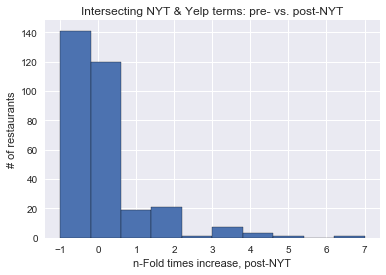

In [405]:
# Index of restaurants whose intersecting terms w/ NYT review is greater post-NYT vs. pre-
#idx_greaterafter = [idx for idx, row in df_influence2.iterrows() if row['after_intersect_total']>row['before_intersect_total']]
# df = df_influence2.loc[idx_greaterafter]

# Calculate difference, pre- vs. post-NYT
difference = []
for idx, row in df_influence2.iterrows():
    if row['before_intersect_total']==0:
        d = row['after_intersect_total']
    else:
        d = (row['after_intersect_total'] - row['before_intersect_total'])/row['before_intersect_total']
    difference.append(d)
df_influence2['difference_intersect'] = difference

# Visualize distribution
plt.hist(difference);
plt.title('Intersecting NYT & Yelp terms: pre- vs. post-NYT');
plt.xlabel('n-Fold times increase, post-NYT');
plt.ylabel('# of restaurants');

The post-NYT increases in intersecting NYT & Yelp words varies. In the majority of cases, the n-fold increase is < 1. 
- It's noteworthy that for those restaurants in which a <i>decrease</i> in intersecting NYT-Yelp terms occurred, it's never greater than 1. This means NYT reviews did not cause any unusual n-fold decrease in intersecting terms - such an anomoly would  might undermine the validity of using NYT reviews to evaluate its role in publicizing specific dishes.

Let's focus on those w/ >= 0.5-fold increases (an increase of intersecting terms of at least 1/2 as many as before, post-NYT).

#### "Good" NYT ratings - influence on n-fold increases?

Are "good" NYT ratings (Critic's Pick and/or NYT stars) more likely to experience >=0.5-fold increase in shared NYT & Yelp words?

In [478]:
df1 = df_influence2[df_influence2['difference_intersect']>=.5]
df2 = df_influence2[df_influence2['difference_intersect']<.5]

print("% restaurants w/ 'good' ratings (Critic's Pick and/or NYT stars)")
print(">=1-fold increase, post-NYT: ", len(df1[ (df1['nyt_stars']>3) | (df1['critics_pick']=='y')  ])/len(df1))
print("<1-fold increase, post-NYT: ", len(df2[ (df2['nyt_stars']>3) | (df2['critics_pick']=='y')  ])/len(df2),'\n')

print('Number of restaurants w/ "good" ratings: ', len(df1))

% restaurants w/ 'good' ratings (Critic's Pick and/or NYT stars)
>=1-fold increase, post-NYT:  0.7681159420289855
<1-fold increase, post-NYT:  0.6979591836734694 

Number of restaurants w/ "good" ratings:  69


Here are a few samples of such changes in intersecting terms:

In [424]:
print('Davelle: \n')
print('pre-NYT shared terms: ', df_influence2.loc[0]['before_intersect'])
print('post-NYT shared terms: ', df_influence2.loc[0]['after_intersect'],'\n')

print('Rangoon Spoon: \n')
print('pre-NYT shared terms: ', df_influence2.loc[3]['before_intersect'])
print('post-NYT shared terms: ', df_influence2.loc[3]['after_intersect'],'\n')

Davelle: 

pre-NYT shared terms:  {'oden'}
post-NYT shared terms:  {'daikon', 'uni', 'spaghetti', 'urchin', 'dashi', 'hokkaido', 'mentaiko', 'oden'} 

Rangoon Spoon: 

pre-NYT shared terms:  {'noodle', 'burmese'}
post-NYT shared terms:  {'spoon', 'tofu', 'rangoon', 'thoke', 'burmese'} 



## 4.3 Conclusion
Among the restaurants w/ at least a 0.5-fold, post-NYT increase in NYT-Yelp shared words, ~76% had a "good" NYT review. Conversely, among <0.5-fold increase restaurants (i.e. insignificant post-NYT change), ~70% had a "good' NYT review.  

The difference may seem significant, but we should keep in mind that the sample size per a group is very asymmetrical (numbers below). As a result, we perform a permutation test in the next section to attempt a test for significance.

In [523]:
df_good = df_influence2[(df_influence2['nyt_stars']>3) | (df_influence2['critics_pick']=='y')]
df_bad = df_influence2[(df_influence2['critics_pick']=='n') & (df_influence2['nyt_stars'].isnull()==True)]

print('Number of "good"-NYT reviewed restaurants: ', len(df_good))
print('Number of "bad"-NYT reviewed restaurants: ', len(df_bad), '\n')

print('Number of >=0.5-fold increased restaurants: ', len(df1))
print('Number of <0.5-fold increased restaurants: ', len(df2))

Number of "good"-NYT reviewed restaurants:  224
Number of "bad"-NYT reviewed restaurants:  60 

Number of >=0.5-fold increased restaurants:  69
Number of <0.5-fold increased restaurants:  245


# 5. Permutation test - NYT-Yelp shared words

Since our distribution of NYT-Yelp word intersections is non-normal, we use a nonparametric test called the [permutation test](https://www2.stat.duke.edu/~ar182/rr/examples-gallery/PermutationTest.html), which is similiar to bootstrapping. 
- "Control" group - the bad/neutral NYT reviewed restaurants, in which no change in post-NYT NYT-Yelp shared words would be expected

## 5.1 "Good" NYT restaurants - stars and/or "Critic's Pick"

We use the same classification for a "good" NYT review that we used in section 4: either receiving stars and/or the "Critic's Pick" label. Our two groups are: 1) "good"-NYT reviewed restaurants, 2) neutrally-reviewed restaurants in which neither a "Critic's Pick" nor NYT stars were awarded.

#### Set up permutation test and function. 

Function for permutation test (adapted from [here](https://www2.stat.duke.edu/~ar182/rr/examples-gallery/PermutationTest.html)).

In [488]:
# permutation function
def run_permutation_test(pooled,sizeZ,sizeY):
    np.random.shuffle(pooled)
    starZ = pooled[:sizeZ]
    starY = pooled[-sizeY:]
    return starZ.mean() - starY.mean()

#### Run test

In [524]:
# separate data into 2 groups
z = df_good['difference_intersect'] # possibily "significant" pre- vs. post-NYT differences in # of shared words
y = df_bad['difference_intersect'] # "control" group w/ no significant difference

# calculate diff between the 2 groups
delta = z.mean() - y.mean()
print('Difference between control & expt group: ', delta)

Difference between control & expt group:  0.10468891723356008


In [525]:
pooled = np.hstack([z,y])
numSamples = 10000
estimates = np.array(list(map(lambda x: run_permutation_test(pooled,z.size,y.size),range(numSamples))))
diffCount = len(np.where(estimates >=delta)[0])
hat_asl_perm = 1.0 - (float(diffCount)/float(numSamples))
hat_asl_perm

0.25370000000000004

Unfortunately, since our p-value is > 0.05, we fail to reject the null hypothesis that there is no difference between the "control" (i.e. group in which there is no significant pre- vs. post-NYT change in # of word intersections) and "experimental" group (w/ >=0.5-fold post-NYT change).

# 6. Conclusion

In our previous notebook (`data_NYT_influence`), we found that restaurants w/ positive NYT reviews were slightly more likely to experience in increase in average Yelp rating afterwards. Since the results were less than expected, we also explored impact on Yelp popularity and found a larger increase. 

There were undoubtly other features at play, and here we explore whether NYT influenced the language of Yelp reviews. More specifically, would mentions of certain dishes in a NYT review increase mentions in Yelp reviews afterwards (i.e. implying that more people ordered the dish)? We used <i>tfidf</i> to improve our hits of cuisine-specific terms and compared Yelp reviews, pre- & post-NYT review publication. 

<b>Results</b>: Setting a threshold of 0.5-fold for the post-NYT increase in shared NYT-Yelp words, we initially had promising results: among restaurants experiencing at least a 0.5-fold post NYT increase, 76% had a "good" NYT review (vs. 70% for <0.5-fold increase). This would seem to suggest that having a positive NYT review would increase the likelihood that Yelp reviews would experience a post-NYT boost in shared, mostly dish-specific terms.

However, upon doing a significance test (permutation test), we could not find this difference to be significant. Thus, we cannot conclude that a positive NYT review will impact Yelp reviews, at least language-wise.

In the process, we: 
- <b>Set up a pipeline for NLP</b> - including pre-processing, generating a corpus, bag of words, CountVectorizer sparse DTM, etc. 
- <b>Classified "good" & "bad" reviews</b> - Discovered words (and word frequencies) associated with "good" & "bad" reviews. Successfully explored classification for "good" & "bad" reviews. Our Naive Bayes classifier worked fairly well, with an accuracy score of ~90%. 
- <b>Explored the influence of NYT reviews on Yelp review language</b> - Set up a method for determining whether restaurants receiving positive NYT reviews would be more likely to experience a greater number of shared words between NYT and Yelp reviews, after the NYT reviews were published.
- <b>NYT-Yelp shared words significance test</b> - Applied permutation test to determine whether the difference between pre- & post-NYT NYT-Yelp shared words was significant.